## Calculating P(m,n)


Load in numpy and ypred_module. 

Currently the path to the model is './models/20220422_cheb_hyp_MODEL' but if you save it to another directory, change that at the top of ypred_module.py before importing.

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import ypred_module as ypm
import torch
# import scipy
# from scipy import stats
import time

Define some p vector (log of b, beta, gamma) as an array.

In [4]:
p = np.array([1.0048,  -0.6288,  -0.6148])

And get the probability at n, m!

In [5]:
ypm.get_prob(p,nas=7,mat=8)

5.0763739840136876e-05

# Plotting


Compare predictions to stored ground truth. 


First load in data.

In [6]:
path ='/home/mcarilli/CME/2D_CME/learning_environment/training_data_quadvec/'

data_array = np.load(path+'256_0.npy',allow_pickle=True)

Choose a pdf to plot.

In [7]:
i = 103

pdf = data_array[i][1]
p = data_array[i][0]

pdf.shape

(31, 55)

A little slow.

In [8]:
predicted = np.zeros((pdf.shape))

for n in range(pdf.shape[0]):
    for m in range(pdf.shape[1]):
        
        P = ypm.get_prob(p,n,m)
        predicted[n,m] = P


In [76]:
def approximate_conditional(p,n,m):
    p = torch.tensor(10**p)
    MU, VAR, STD, xmax = [torch.tensor( x) for x in ypm.get_moments(p)]
    
    COV = p[0]**2/(p[1]+p[2])
    n = torch.tensor(n)
    m = torch.tensor(m)
    
    logvar = torch.log((VAR/MU**2)+1)
    logstd = torch.sqrt(logvar)
    logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))

    logcov = torch.log(COV * torch.exp(-(logmean.sum()+logvar.sum()/2)) +1 ) 
    logcorr = logcov/torch.sqrt(logvar.prod())

    logmean_cond = logmean[1] + logcorr * logstd[1]/logstd[0] * (torch.log(n+1) - logmean[0])
    logstd_cond = logstd[1] * torch.sqrt(1-logcorr**2)   
    logvar_cond = logstd_cond**2

    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)

    r = 1/p[1]
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+MU[0])) + n * torch.log(MU[0]/(r+MU[0]))
    
    if r>0 and p_cond>0 and p_cond<1:
        y_ = torch.lgamma(m+r_cond) - torch.lgamma(m+1) - torch.lgamma(r_cond) \
                + r_cond * torch.log(r_cond/(r_cond+mean_cond)) + m * torch.log(mean_cond/(r_cond+mean_cond))
    else: 
        y_ = m*torch.log(mean_cond) - mean_cond - torch.lgamma(m+1) 
    P = prefactor +  y_

    return np.exp(P)


In [136]:
def approximate_conditional_tensorval(p,n,m):
    p = torch.tensor(10**p)
    MU, VAR, STD, xmax = [torch.tensor(x) for x in ypm.get_moments(p)]
    
    COV = p[0]**2/(p[1]+p[2])
    n = torch.tensor(n)
    m = torch.tensor(m)
    
    logvar = torch.log((VAR/MU**2)+1)
    logstd = torch.sqrt(logvar)
    logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))

    logcov = torch.log(COV * torch.exp(-(logmean.sum()+logvar.sum()/2)) +1 ) 
    logcorr = logcov/torch.sqrt(logvar.prod())

    logmean_cond = logmean[1] + logcorr * logstd[1]/logstd[0] * (torch.log(n+1) - logmean[0])
    logvar_cond = logvar[1] * (1-logcorr**2)   

    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)

    r = 1/p[1]
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+MU[0])) + n * torch.log(MU[0]/(r+MU[0]))

    y_ = m * torch.log(mean_cond) - mean_cond - torch.lgamma(m+1) 
    filt = torch.logical_and(torch.logical_and(r>0,p_cond>0), p_cond<1)
    y_[filt] += torch.lgamma(m[filt]+r_cond[filt])  - torch.lgamma(r_cond[filt]) \
                + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])) \
                - m[filt] * torch.log(r_cond[filt]+mean_cond[filt]) + mean_cond[filt]

    P = prefactor +  y_

    return np.exp(P)


In [113]:
N,M = np.meshgrid(range(pdf.shape[0]),range(pdf.shape[1]),indexing='ij')
# N = N.flatten()
# M = M.flatten()

In [114]:
t1 = time.time()
predicted_nb = np.zeros((pdf.shape))

for n in range(pdf.shape[0]):
    for m in range(pdf.shape[1]):
        
        P = approximate_conditional(p,n,m)
        predicted_nb[n,m] = P

t2 = time.time()
print('Runtime: {:.6f} seconds.'.format(t2-t1))

/tmp/ipykernel_59604/4272770790.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MU, VAR, STD, xmax = [torch.tensor( x) for x in ypm.get_moments(p)]


Runtime: 14.702930 seconds.


In [137]:
t1 = time.time()
predicted_nb = approximate_conditional_tensorval(p,N,M).detach().numpy()
t2 = time.time()
print('Runtime: {:.6f} seconds.'.format(t2-t1))

Runtime: 0.003915 seconds.


/tmp/ipykernel_59604/1393527614.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MU, VAR, STD, xmax = [torch.tensor(x) for x in ypm.get_moments(p)]


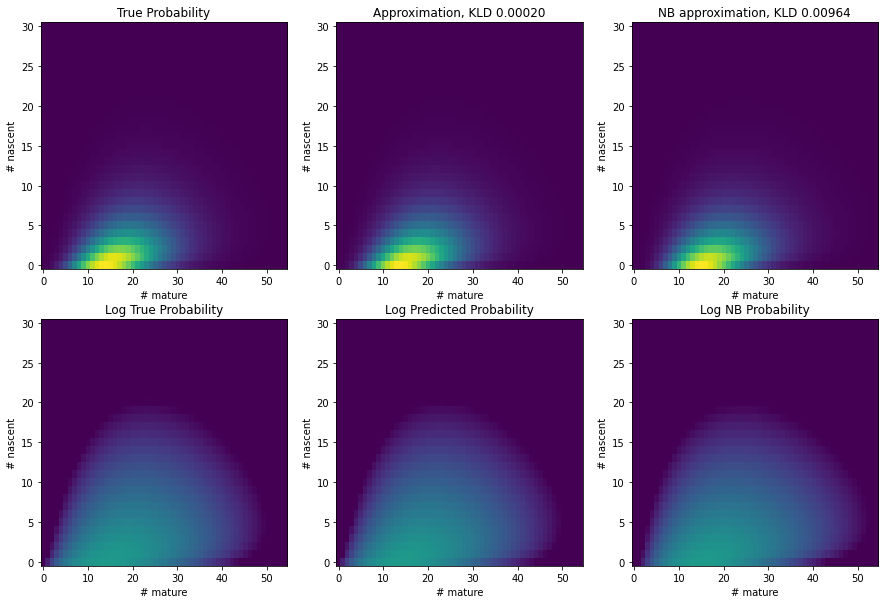

In [138]:
P = pdf
Papprox = predicted

Plog = np.log(P)
Papproxlog = np.log(Papprox)
Pnblog = np.log(predicted_nb)

fig1,ax1=plt.subplots(nrows=2,ncols=3,figsize=(15,10))

ax1[0,0].imshow(P,aspect='auto')
ax1[0,0].invert_yaxis()
ax1[0,0].set_title('True Probability')
ax1[0,0].set_xlabel('# mature')
ax1[0,0].set_ylabel('# nascent')

KLD = -np.sum(P.flatten()*np.log(Papprox.flatten()/P.flatten()))
ax1[0,1].imshow(Papprox,aspect='auto')
ax1[0,1].invert_yaxis()
ax1[0,1].set_title(f'Approximation, KLD {KLD:.5f}')
ax1[0,1].set_xlabel('# mature')
ax1[0,1].set_ylabel('# nascent')


ax1[1,0].imshow(Plog,aspect='auto',vmin=-10,vmax=0)
ax1[1,0].invert_yaxis()
ax1[1,0].set_title(f'Log True Probability')
ax1[1,0].set_xlabel('# mature')
ax1[1,0].set_ylabel('# nascent')

ax1[1,1].imshow(Papproxlog,aspect='auto',vmin=-10,vmax=0)
ax1[1,1].invert_yaxis()
ax1[1,1].set_title(f'Log Predicted Probability')
ax1[1,1].set_xlabel('# mature')
ax1[1,1].set_ylabel('# nascent');


KLD = -np.sum(P.flatten()*np.log(predicted_nb.flatten()/P.flatten()))
ax1[0,2].imshow(predicted_nb,aspect='auto')
ax1[0,2].invert_yaxis()
ax1[0,2].set_title(f'NB approximation, KLD {KLD:.5f}')
ax1[0,2].set_xlabel('# mature')
ax1[0,2].set_ylabel('# nascent')


ax1[1,2].imshow(Pnblog,aspect='auto',vmin=-10,vmax=0)
ax1[1,2].invert_yaxis()
ax1[1,2].set_title(f'Log NB Probability')
ax1[1,2].set_xlabel('# mature')
ax1[1,2].set_ylabel('# nascent');